# Generative Model Benchmarking

The goal here is to use the [data programing paradigm](https://arxiv.org/abs/1605.07723) to probabilistically label our training dataset for the disease associates gene relationship. The label functions have already been generated and now it is time to train the generative model. This model captures important features such as agreements and disagreements between label functions, by estimating the probability of label functions emitting a combination of labels given the class. $P(\lambda_{i} = j \mid Y=y)$. More information can be found in this [technical report](https://arxiv.org/pdf/1810.02840.pdf) or in this [paper](https://ajratner.github.io/assets/papers/deem-metal-prototype.pdf). The testable hypothesis here is: **Incorporating multiple weak sources improves performance compared to the normal distant supervision approach, which uses a single resource for labels**.

# Experimental Design:

Compares three different models. The first model uses four databases (DisGeNET, Diseases, DOAF and GWAS) as the distant supervision approach. The second model uses the above databases with user defined rules such as (regular expressions, trigger word identification and sentence contextual rules). The last model uses the above sources of information in conjunction with biclustering data obtained from this [paper](https://www.ncbi.nlm.nih.gov/pubmed/29490008).

## Dataset
    
| Set type  | Size |
|:---|:---|
| Train |  50k  |
| Dev |  500 (hand labeled) |

## Set up The Environment

The few blocks below sets up our python environment to perform the experiment.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from itertools import product
import os
import pickle
import sys

sys.path.append(os.path.abspath('../../../modules'))

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.annotations import LabelAnnotator
from snorkel.learning.structure import DependencySelector
from snorkel.models import candidate_subclass

from metal.analysis import confusion_matrix, lf_summary
from metal.label_model import LabelModel
from metal.utils import convert_labels
from metal.contrib.visualization.analysis import(
    plot_predictions_histogram, 
)

from utils.label_functions.disease_gene_lf_multitask import DG_LFS

from utils.notebook_utils.dataframe_helper import load_candidate_dataframes
from utils.notebook_utils.label_matrix_helper import (
    get_auc_significant_stats, 
    get_overlap_matrix, 
    get_conflict_matrix, 
    label_candidates
)
from utils.notebook_utils.train_model_helper import train_generative_model
from utils.notebook_utils.plot_helper import (
    plot_label_matrix_heatmap, 
    plot_curve, 
    plot_generative_model_weights, 
)

In [4]:
DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])

In [5]:
quick_load = True

## Load the data for Generative Model Experiments

In [6]:
spreadsheet_names = {
    'train': 'data/sentence_labels_train.xlsx',
    'dev': 'data/sentence_labels_dev.xlsx',
}

In [7]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key])
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of train set: 50000
Size of dev set: 500


In [8]:
label_functions = (
    list(DG_LFS["DaG"].values())
) 

if quick_load:
    label_matricies = pickle.load(open("data/label_matricies.pkl", "rb"))
else:
    label_matricies = {
        key:label_candidates(
            session,
            candidate_dfs[key]['candidate_id'],
            label_functions,
            num_threads=10, 
            batch_size=candidate_dfs[key]['candidate_id'].shape[0]
        )
        for key in candidate_dfs
    }
    pickle.dump(label_matricies, open("data/label_matricies.pkl", "wb"))

In [9]:
lf_names = list(DG_LFS["DaG"].keys())

## Visualize Label Functions

Before training the generative model, here are some visualizations for the given label functions. These visualizations are helpful in determining the efficacy of each label functions as well as observing the overlaps and conflicts between each function.

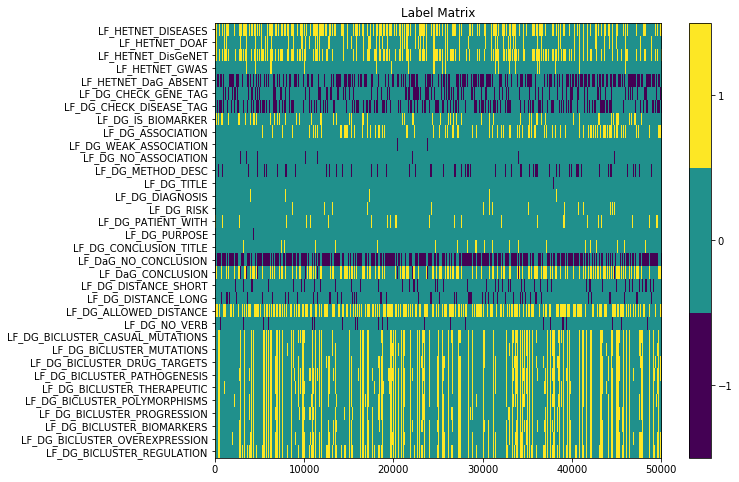

In [10]:
plt.rcParams.update({'font.size': 10})
plot_label_matrix_heatmap(label_matricies['train'].T, 
                          yaxis_tick_labels=lf_names, 
                          figsize=(10,8), font_size=10)

Looking at the heatmap above, this is a decent distribution of labels. Some of the label functions are covering a lot of data points (distant supervision ones) and some are very sparse in their output.

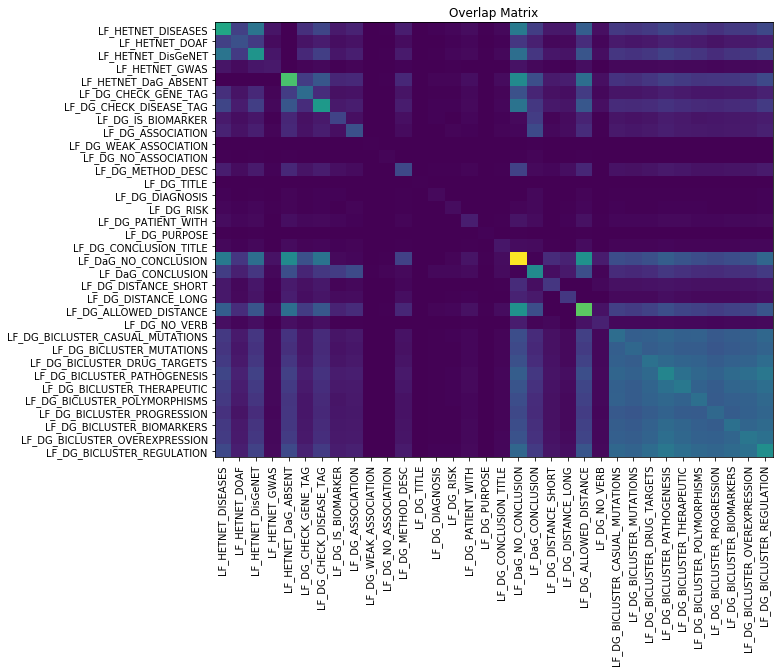

In [11]:
plot_label_matrix_heatmap(get_overlap_matrix(label_matricies['train'], normalize=True), 
                          yaxis_tick_labels=lf_names, xaxis_tick_labels=lf_names,
                          figsize=(10,8), colorbar=False, plot_title="Overlap Matrix")

The overlap matrix above shows how two label functions overlap with each other. The brighter the color the more overlaps a label function has with another label function.

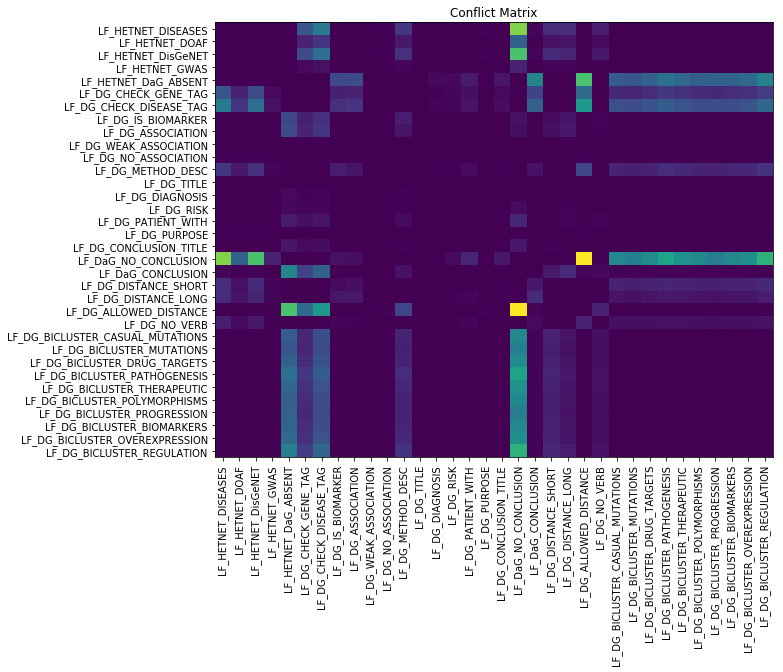

In [12]:
plot_label_matrix_heatmap(get_conflict_matrix(label_matricies['train'], normalize=True), 
                          yaxis_tick_labels=lf_names, xaxis_tick_labels=lf_names,
                          figsize=(10,8), colorbar=False, plot_title="Conflict Matrix")

The conflict matrix above shows how often label functions conflict with each other. The brighter the color the more conflict a label function has with another function. Ignoring the diagonals, there isn't many conflicts between functions except for the LF_DG_NO_CONCLUSION and LF_DG_ALLOWED_DISTANCE.

# Train the Generative Model

After visualizing the label functions and their associated properties, now it is time to work on the generative model. As with common machine learning pipelines, the first step is to find the best hyperparameters for this model. Using the grid search algorithm, the follow parameters were optimized: amount of burnin, strength of regularization, number of epochs to run the model.

## Set the hyperparameter grid search

In [13]:
regularization_grid = pd.np.round(pd.np.linspace(0.1, 6, num=25), 3)

## What are the best hyperparameters for the conditionally independent model?

In [37]:
L = convert_labels(label_matricies['train'].toarray(), 'plusminus', 'categorical')
L_dev = convert_labels(label_matricies['dev'].toarray(), 'plusminus', 'categorical')
L_test = convert_labels(label_matricies['test'].toarray(), 'plusminus', 'categorical')

validation_data = list(zip([L[:,:7], L[:, :24], L], [L_dev[:,:7], L_dev[:, :24], L_dev]))
test_data = list(zip([L[:,:7], L[:, :24], L], [L_test[:,:7], L_test[:, :24], L_test]))
model_labels = ["Knowledge Bases (KB)", "KB+Text Patterns", "All"]

In [15]:
model_grid_search = {}
for model_data, model_label in zip(validation_data, model_labels):
    
    label_model = LabelModel(k=2, seed=100)
    grid_results = {}
    for param in regularization_grid:
        label_model.train_model(model_data[0], n_epochs=1000, verbose=False, lr=0.01, l2=param)
        grid_results[str(param)] = label_model.predict_proba(model_data[1])[:,0]
        
    model_grid_search[model_label] = pd.DataFrame.from_dict(grid_results)

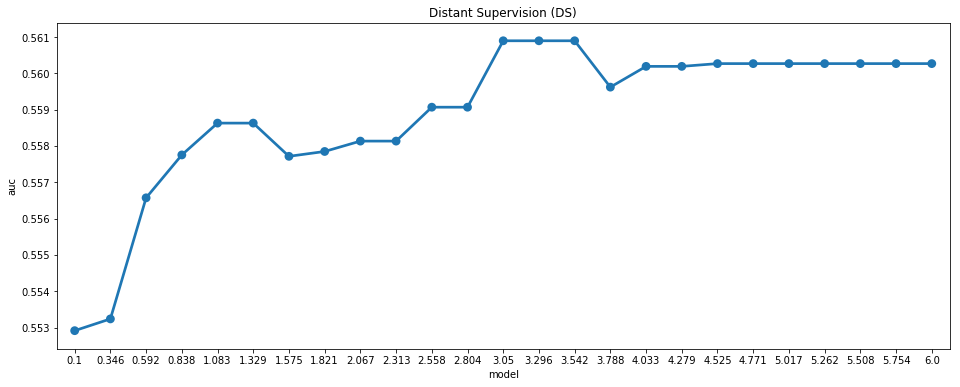

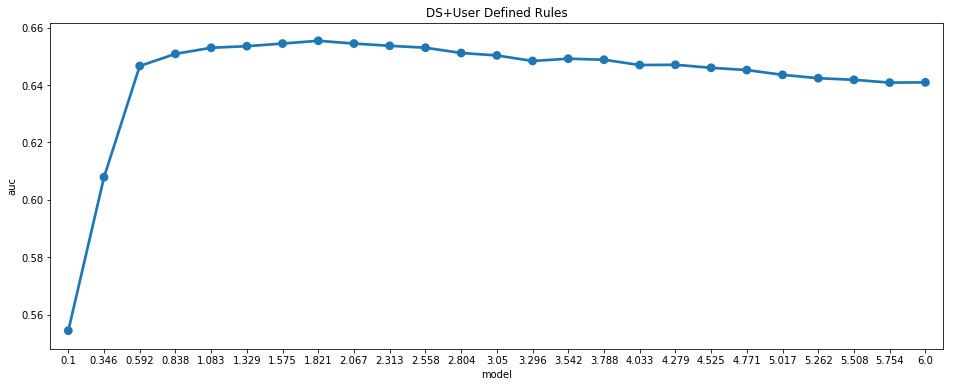

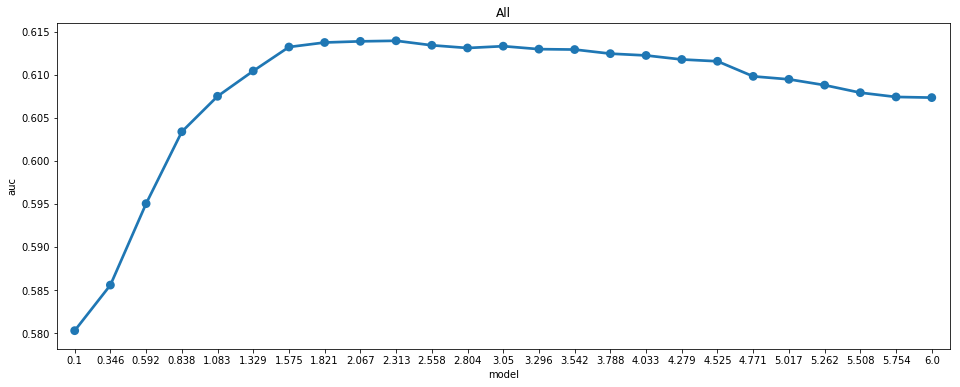

In [16]:
model_grid_aucs = {}
for model in model_grid_search:
    model_grid_aucs[model] = plot_curve(model_grid_search[model], candidate_dfs['dev'].curated_dsh, 
                               figsize=(16,6), model_type='scatterplot', plot_title=model, metric="ROC", font_size=10)

In [17]:
model_grid_auc_dfs = {}
for model in model_grid_aucs:
    model_grid_auc_dfs[model] = (
        get_auc_significant_stats(candidate_dfs['dev'], model_grid_aucs[model])
        .sort_values('auroc', ascending=False)
    )
    print(model)
    print(model_grid_auc_dfs[model].head(5))
    print()

mu: 26250.000000, sigma: 1480.498227
Distant Supervision (DS)
          auroc        u       z_u   p_value
3.05   0.560895  29447.0  2.159408  0.015409
3.296  0.560895  29447.0  2.159408  0.015409
3.542  0.560895  29447.0  2.159408  0.015409
5.754  0.560267  29414.0  2.137118  0.016294
5.508  0.560267  29414.0  2.137118  0.016294

mu: 26250.000000, sigma: 1480.498227
DS+User Defined Rules
          auroc        u       z_u       p_value
1.821  0.655390  34408.0  5.510307  1.791040e-08
1.575  0.654419  34357.0  5.475859  2.176968e-08
2.067  0.654419  34357.0  5.475859  2.176968e-08
2.313  0.653638  34316.0  5.448166  2.544594e-08
1.329  0.653505  34309.0  5.443438  2.613100e-08

mu: 26250.000000, sigma: 1480.498227
All
          auroc        u       z_u   p_value
2.313  0.613943  32232.0  4.040532  0.000027
2.067  0.613876  32228.5  4.038168  0.000027
1.821  0.613743  32221.5  4.033439  0.000027
2.558  0.613419  32204.5  4.021957  0.000029
3.05   0.613314  32199.0  4.018242  0.000029



# Final Evaluation on Held out Hand Labeled Test Data

In [39]:
dev_model_df = pd.DataFrame()
for best_model, model_data, model_label in zip([1.083, 2.067, 1.575], validation_data, model_labels):
    label_model = LabelModel(k=2, seed=100)
    label_model.train_model(model_data[0] , n_epochs=1000, verbose=False, lr=0.01, l2=best_model)
    dev_model_df[model_label] = label_model.predict_proba(model_data[1])[:,0]

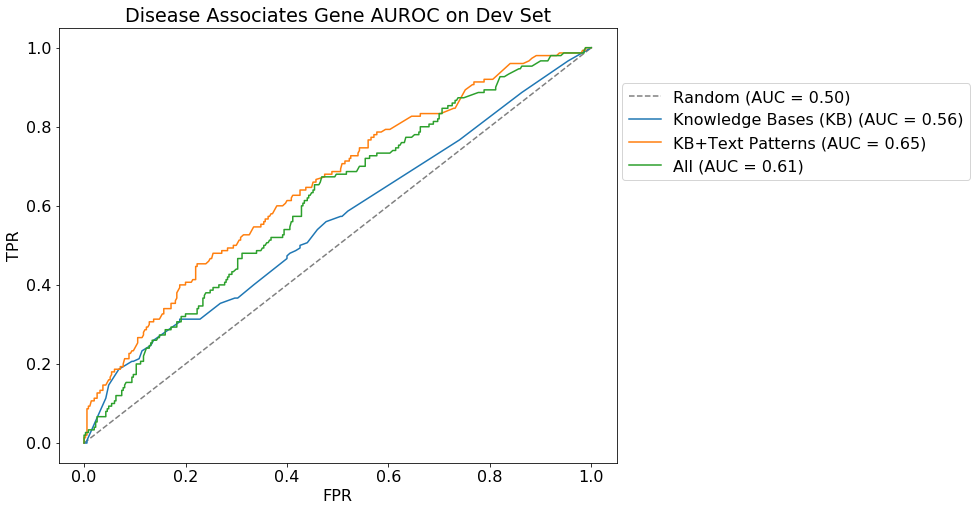

In [40]:
_ = plot_curve(
    dev_model_df, 
    candidate_dfs['dev'].curated_dsh,
    model_type='curve', figsize=(10,8), 
    plot_title="Disease Associates Gene AUROC on Dev Set", font_size=16
)

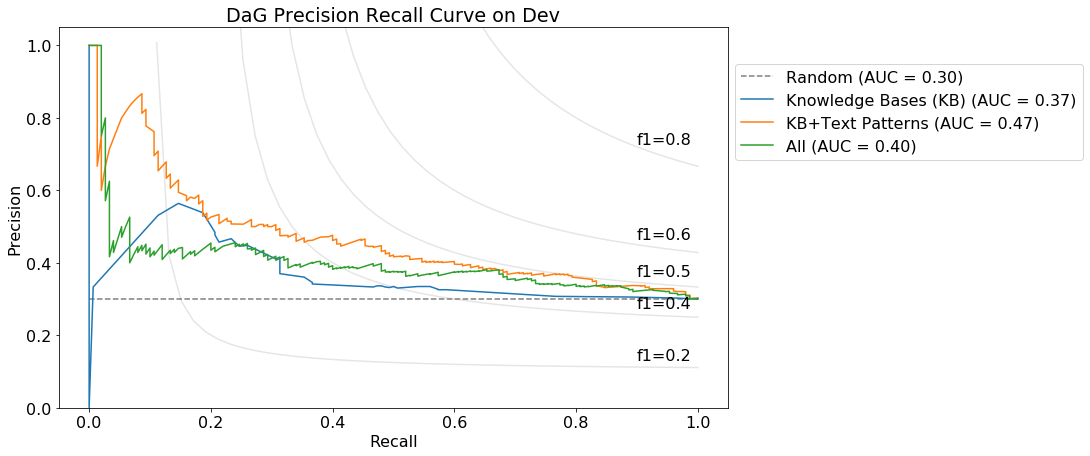

In [43]:
_ = plot_curve(
    dev_model_df, 
    candidate_dfs['dev'].curated_dsh,
    model_type='curve', figsize=(12,7), 
    plot_title="DaG Precision Recall Curve on Dev",
    metric='PR', font_size=16
)

In [21]:
label_model = LabelModel(k=2, seed=100)
label_model.train_model(validation_data[1][0], n_epochs=1000, verbose=False, lr=0.01, l2=2.067)
dev_predictions = convert_labels(label_model.predict(validation_data[1][1]), 'categorical', 'onezero')
dev_marginals = label_model.predict_proba(validation_data[1][1])[:,0]

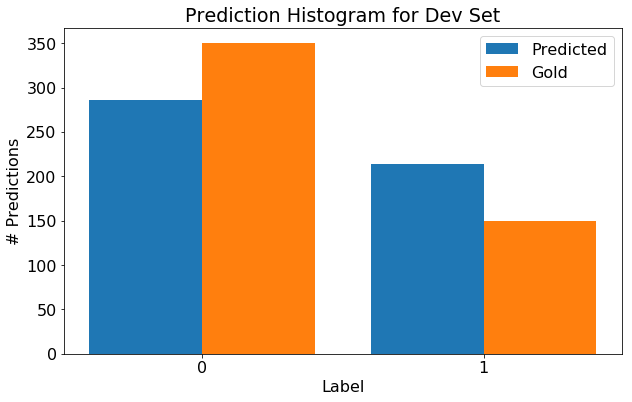

In [22]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,6))
plot_predictions_histogram(
    dev_predictions,
    candidate_dfs['dev'].curated_dsh.astype(int).values,
    title="Prediction Histogram for Dev Set"
)

In [23]:
confusion_matrix(
    convert_labels(candidate_dfs['dev'].curated_dsh.values, 'onezero', 'categorical'),
    convert_labels(dev_predictions, 'onezero', 'categorical')
)

        y=1    y=2   
 l=1    86     64    
 l=2    128    222   


array([[ 86,  64],
       [128, 222]])

In [25]:
lf_summary(label_matricies['dev'], Y=candidate_dfs['dev'].curated_dsh.apply(lambda x: 1 if x > 0 else 2).values, lf_names=lf_names)

/home/danich1/Documents/metal/metal/analysis.py:131: RuntimeWarning: invalid value encountered in true_divide
  return 0.5 * (X.sum(axis=0) / (L != 0).sum(axis=0) + 1)


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
LF_HETNET_DISEASES,0,1,0.418,0.418,0.354,69,140,0.330144
LF_HETNET_DOAF,1,1,0.186,0.186,0.158,33,60,0.354839
LF_HETNET_DisGeNET,2,1,0.390,0.390,0.330,67,128,0.343590
LF_HETNET_GWAS,3,1,0.050,0.050,0.040,12,13,0.480000
LF_HETNET_DaG_ABSENT,4,-1,0.460,0.460,0.460,168,62,0.000000
LF_DG_CHECK_GENE_TAG,5,-1,0.286,0.286,0.286,106,37,0.000000
LF_DG_CHECK_DISEASE_TAG,6,-1,0.334,0.334,0.334,121,46,0.000000
LF_DG_IS_BIOMARKER,7,1,0.140,0.140,0.106,25,45,0.357143
LF_DG_ASSOCIATION,8,1,0.140,0.140,0.108,36,34,0.514286
LF_DG_WEAK_ASSOCIATION,9,-1,0.002,0.002,0.002,1,0,0.000000


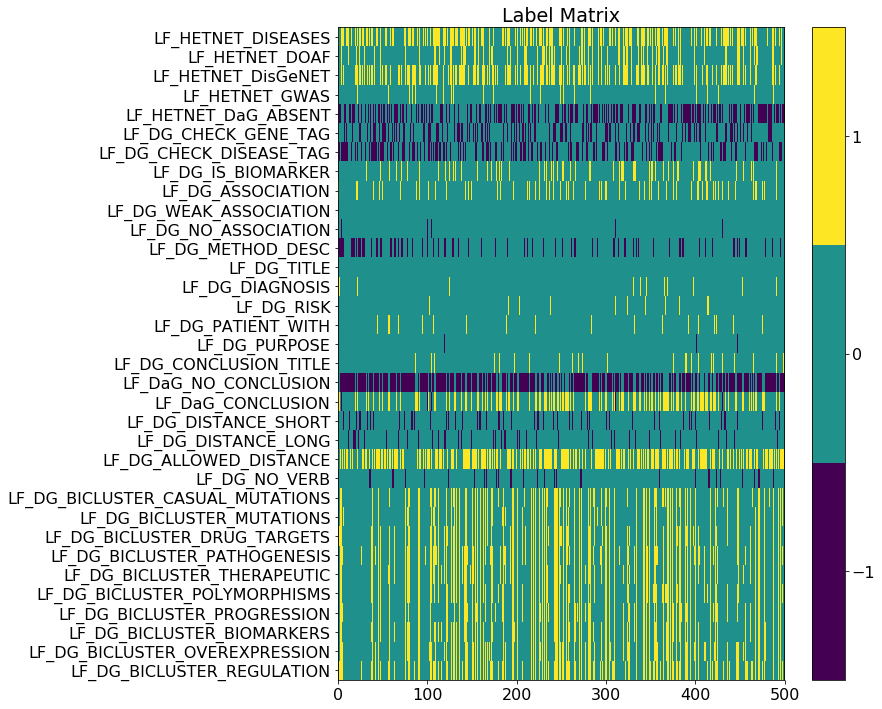

In [26]:
plot_label_matrix_heatmap(convert_labels(label_matricies['dev'].toarray(), 'categorical', 'plusminus').T, 
                          yaxis_tick_labels=lf_names, 
                          figsize=(10,12), font_size=10)

In [27]:
pickle.dump(label_model.predict_proba(L[:, :24]), open("data/train_marginals.pkl", "wb"))